In [3]:
import zipfile

zfile = zipfile.ZipFile('/content/leapgestrecog.zip')
zfile.extractall('data')

In [4]:
!pip install split-folders

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf

from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization, Flatten, Input
from keras.optimizers import RMSprop, Adam
from keras.models import Model, Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.losses import categorical_crossentropy, CategoricalCrossentropy
from keras.metrics import Accuracy
from keras.utils import plot_model, img_to_array, load_img, save_img
from keras.preprocessing.image import ImageDataGenerator

from splitfolders import ratio

# Explore some images

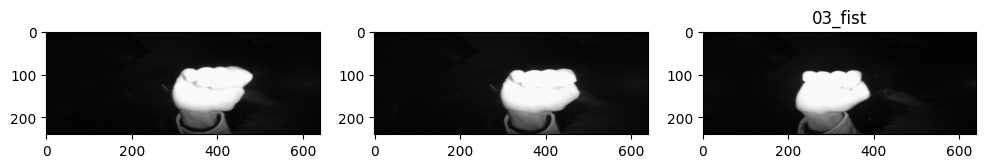

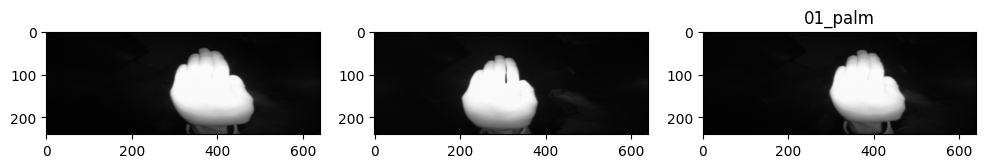

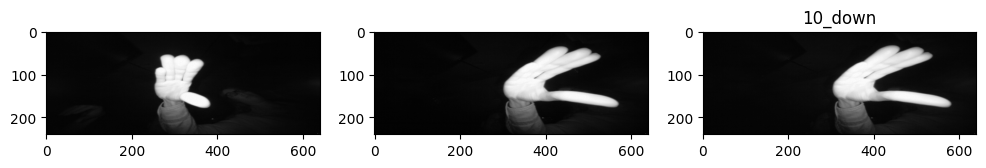

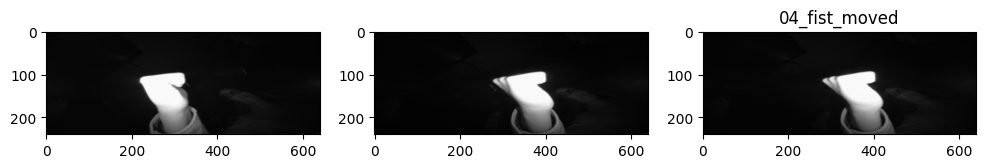

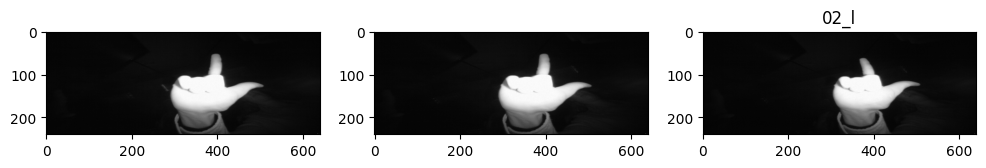

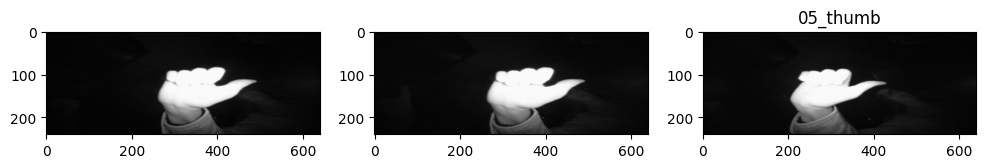

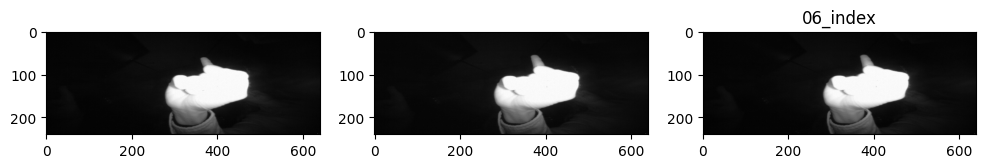

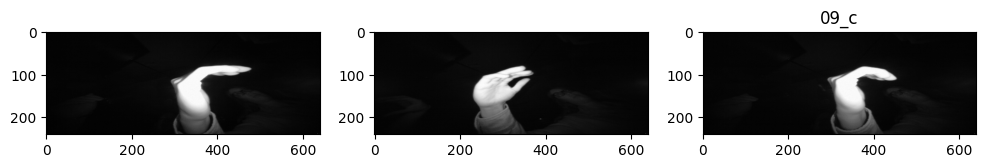

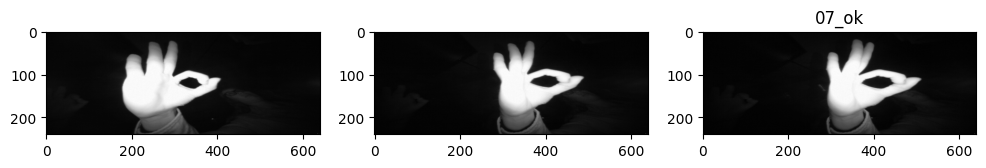

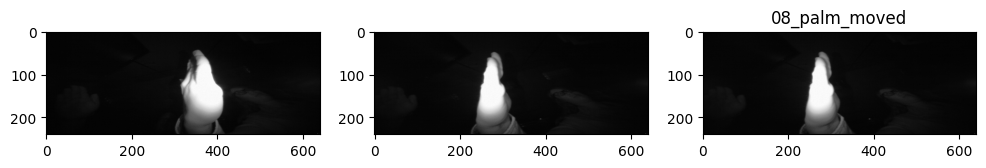

In [6]:
FILE_NAME = '/content/data/leapGestRecog/00'

for folder in os.listdir(FILE_NAME):
  fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12, 8))
  images = os.listdir(FILE_NAME + '/' +folder)
  ax[0].imshow(plt.imread(FILE_NAME+ f'/{folder}/' + images[4]), cmap='gray')
  ax[1].imshow(plt.imread(FILE_NAME+ f'/{folder}/' + images[2]), cmap='gray')
  ax[2].imshow(plt.imread(FILE_NAME+ f'/{folder}/' + images[3]), cmap='gray')
  plt.title(f'{folder}')
  plt.show()

# Read images

In [7]:
ratio(input='/content/data/leapGestRecog/00', output='newdata')

Copying files: 2000 files [00:00, 2384.05 files/s]


In [8]:
data_gen = ImageDataGenerator(rescale=1./255)

train_data = data_gen.flow_from_directory('/content/newdata/train',
                                          target_size=(150, 150),
                                          color_mode='grayscale')

test_data = data_gen.flow_from_directory('/content/newdata/test',
                                          target_size=(150, 150),
                                         color_mode='grayscale')

val_data = data_gen.flow_from_directory('/content/newdata/val',
                                          target_size=(150, 150),
                                        color_mode='grayscale')

Found 1600 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [9]:
classes = list(train_data.class_indices.keys())
classes

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

# Build the model

In [10]:
def build_model():

  model = Sequential([
      Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=(150, 150, 1)),
      MaxPool2D((2, 2)),

      Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
      MaxPool2D((2, 2)),

      Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
      MaxPool2D((2, 2)),

      Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
      MaxPool2D((2, 2)),

      Flatten(),

      Dense(512, activation='relu'),
      Dropout(0.25),

      Dense(256, activation='relu'),
      Dropout(0.25),

      Dense(128, activation='relu'),

      Dense(10, activation='softmax')

  ])

  return model

In [11]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 32)        0

In [12]:
loss = CategoricalCrossentropy()
optimizer = RMSprop()

model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

hist = model.fit(train_data, batch_size=32, epochs=20, validation_data=val_data)

Epoch 1/20
50/50 [==============================] - 25s 228ms/step - loss: 1.5441 - acc: 0.4350 - val_loss: 0.0711 - val_acc: 0.9950
Epoch 2/20
50/50 [==============================] - 4s 89ms/step - loss: 0.1111 - acc: 0.9675 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 3/20
50/50 [==============================] - 4s 79ms/step - loss: 0.0317 - acc: 0.9887 - val_loss: 3.1949e-06 - val_acc: 1.0000
Epoch 4/20
50/50 [==============================] - 4s 78ms/step - loss: 0.0482 - acc: 0.9894 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 5/20
50/50 [==============================] - 5s 93ms/step - loss: 0.0107 - acc: 0.9962 - val_loss: 1.4060e-06 - val_acc: 1.0000
Epoch 6/20
50/50 [==============================] - 4s 79ms/step - loss: 0.0017 - acc: 0.9994 - val_loss: 4.7455e-04 - val_acc: 1.0000
Epoch 7/20
50/50 [==============================] - 4s 80ms/step - loss: 0.0175 - acc: 0.9962 - val_loss: 6.7464e-06 - val_acc: 1.0000
Epoch 8/20
50/50 [==============================] - 5s 93ms/step 

# Visualize the model result

In [13]:
model.evaluate(test_data)

7/7 [==============================] - 0s 56ms/step - loss: 0.0000e+00 - acc: 1.0000


[0.0, 1.0]

In [18]:
img = load_img('/content/newdata/test/03_fist/frame_00_03_0053.png', target_size=(150, 150), color_mode='grayscale')
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array /= 255.0

In [35]:
for class_name in os.listdir('/content/newdata/test'):
  counter = 0
  for img_name in os.listdir('/content/newdata/test'+f'/{class_name}'):
    img = load_img(f'/content/newdata/test/{class_name}/{img_name}', target_size=(150, 150), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array /= 255.0

    counter += 1

    if counter > 5:
      break

    print("predicted class:", classes[np.argmax(model.predict(img_array, verbose=0))])
    print("True ---- class:", f'{class_name}')
  print('-' * 20)

predicted class: 03_fist
True ---- class: 03_fist
predicted class: 03_fist
True ---- class: 03_fist
predicted class: 03_fist
True ---- class: 03_fist
predicted class: 03_fist
True ---- class: 03_fist
predicted class: 03_fist
True ---- class: 03_fist
--------------------
predicted class: 01_palm
True ---- class: 01_palm
predicted class: 01_palm
True ---- class: 01_palm
predicted class: 01_palm
True ---- class: 01_palm
predicted class: 01_palm
True ---- class: 01_palm
predicted class: 01_palm
True ---- class: 01_palm
--------------------
predicted class: 10_down
True ---- class: 10_down
predicted class: 10_down
True ---- class: 10_down
predicted class: 10_down
True ---- class: 10_down
predicted class: 10_down
True ---- class: 10_down
predicted class: 10_down
True ---- class: 10_down
--------------------
predicted class: 04_fist_moved
True ---- class: 04_fist_moved
predicted class: 04_fist_moved
True ---- class: 04_fist_moved
predicted class: 04_fist_moved
True ---- class: 04_fist_moved
p

1/1 [==============================] - 0s 65ms/step


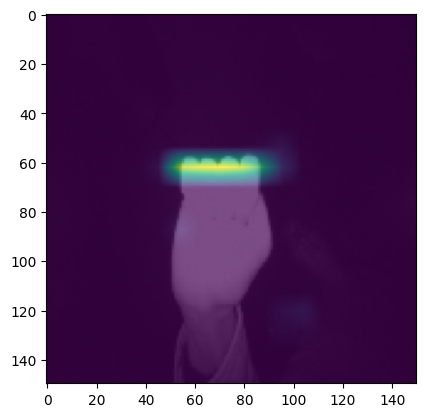

In [20]:
layer_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_3').output)
activation = layer_model.predict(img_array)
activation_img = cv2.resize(activation[0, :, :, 0], (150, 150))
plt.imshow(img_array[0, :, :, :], cmap='gray')
plt.imshow(activation_img, alpha=0.7)
plt.show()

Text(0.5, 1.0, 'accuracy')

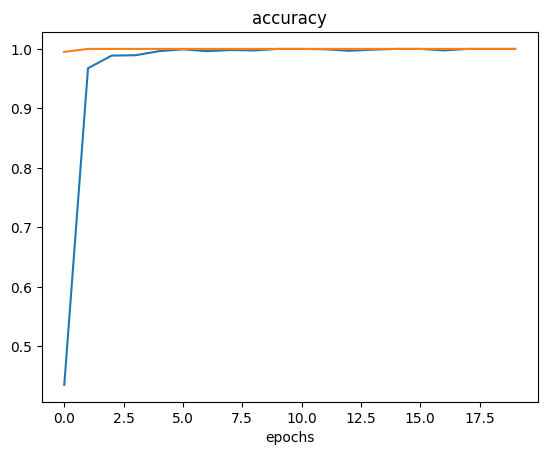

In [23]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.xlabel('epochs')
plt.title('accuracy')

Text(0.5, 1.0, 'accuracy')

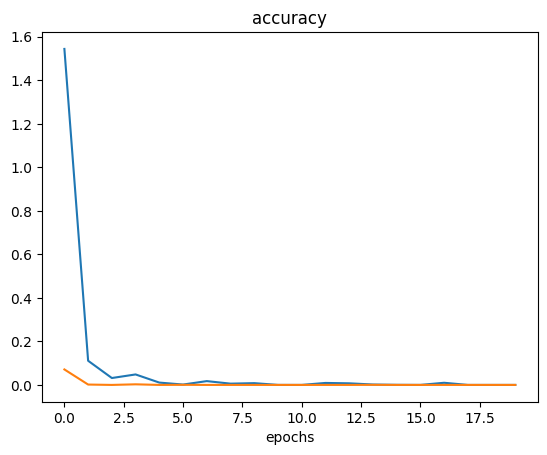

In [26]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.title('accuracy')